# Trading Cointegrated Stocks
Cointegration is a statistical property of a collection of time series variables whereby a linear combination of them is stationary, even though the individual series themselves are non-stationary. In the context of stock prices, cointegration suggests that while individual stock prices may show short-term fluctuations and trends (i.e., they are non-stationary), they share a long-term equilibrium relationship, meaning they move together over time and any deviations from this equilibrium are temporary and will eventually correct themselves. If one stock becomes temporarily overvalued compared to the other, market forces should bring the prices back into alignment over time. Traders and investors can use cointegration analysis to identify pairs of stocks that are cointegrated, enabling them to develop trading strategies such as pairs trading, where they simultaneously buy one stock and sell short the other when they deviate significantly from their long-term relationship, anticipating a reversion to the mean. Our goal is to develop an algorithm which can effectively make a profit off of the spread of two or more stocks. Let's begin by seeing what properties we can find from the price data of Canada's Big 5 Banks: BMO, CIBC, RBC, TD, and Scotiabank. 


In [ ]:
#Go to your terminal and install libraries with pip
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt
import datetime
import yfinance as yf

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


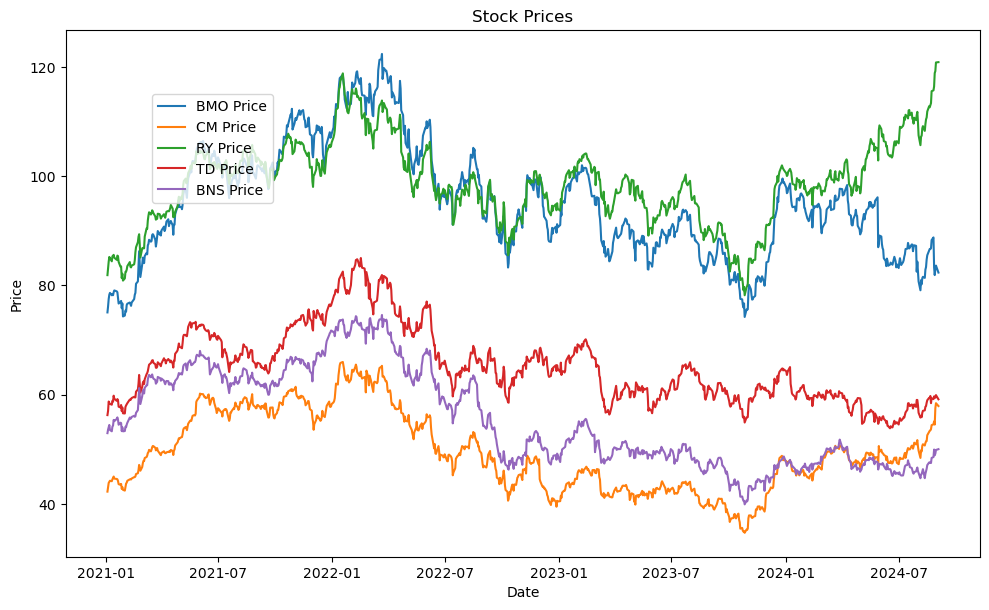

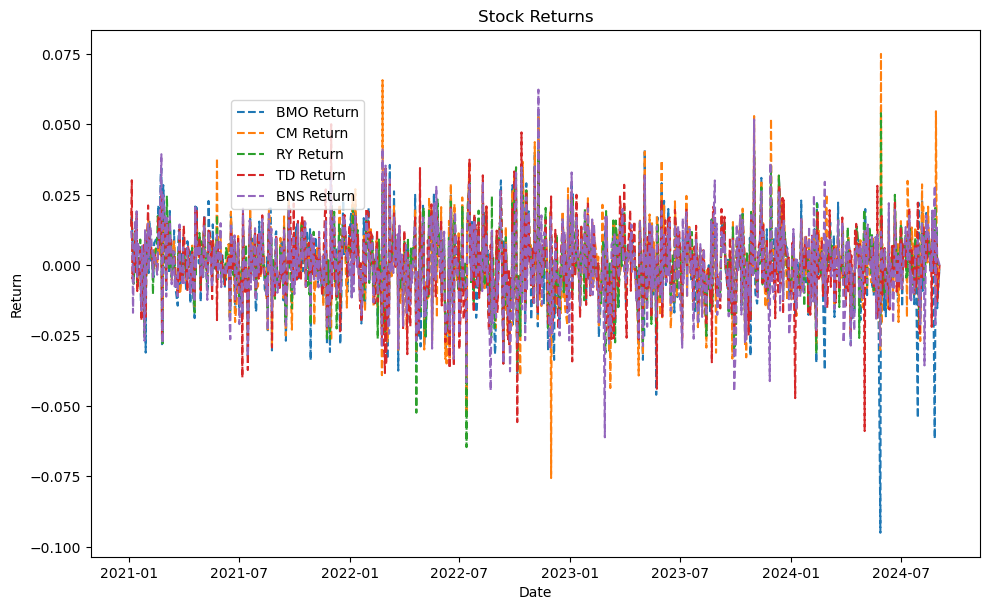

In [12]:
# Initial Parameters
tickers = ['BMO', 'CM', 'RY', 'TD', 'BNS']
start = '2021-01-01'
end = datetime.datetime.now().strftime('%Y-%m-%d')  # current date
# Using Yahoo Finance's daily price data
data = pd.DataFrame()
returns = pd.DataFrame()
# Plot for stock prices
fig1, ax1 = plt.subplots(figsize=(10, 6))
# Plot for stock returns
fig2, ax2 = plt.subplots(figsize=(10, 6))

for stock in tickers:
    prices = yf.download(stock, start, end)
    data[stock] = prices['Close']
    returns[stock] = np.append(data[stock][1:].reset_index(drop=True) / data[stock][:-1].reset_index(drop=True) - 1, 0)
    # Plot stock prices
    ax1.plot(prices.index, prices['Close'], label=f"{stock} Price")
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.tick_params(axis='y')
    # Plot stock returns
    ax2.plot(prices.index, returns[stock], linestyle='--', label=f"{stock} Return")
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Return')
    ax2.tick_params(axis='y')

# Adjust layout and show plots
fig1.tight_layout()
ax1.set_title('Stock Prices')
fig1.legend(loc='upper left', bbox_to_anchor=(0.15, 0.88))
fig2.tight_layout()
ax2.set_title('Stock Returns')
ax2.legend(loc='upper left', bbox_to_anchor=(0.15, 0.88))
plt.show()

By examining this chart, we can see that BMO and RBC appear to have prices which move in the same direction in the long term, but may exhibit different price changes in the short term. We can also see that CIBC, TD, and Scotia may also be cointegrated, but the difference between their prices may exhibit changes over time. When the returns of the 5 stocks are plotted, the fluctuations in prices do not exhibit an obvious pattern, but may have some similarities. Let's perform some statistical tests to explore this further by using the Augmented Dickey-Fuller (ADF) test to check for stationarity in the individual time series and then applying the Engle-Granger two-step cointegration test if the time series are found to be non-stationary.

In [13]:
from statsmodels.tsa.stattools import adfuller
# Define a function to check for cointegration using Engle-Granger method
def check_cointegration(stock, other_stock):
    # Step 1: Regress one stock on another
    X = data[other_stock]
    Y = data[stock]
    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    results = model.fit()
    residuals = results.resid
    # Step 2: Check if residuals are stationary
    coint_p = adfuller(residuals)[1]  # Extracting the p-value
    return coint_p
# Print out the results of an ADF test for each stock
for stock in tickers:
    adf_p = adfuller(data[stock])[1]  # Extracting the p-value
    if adf_p < 0.05:
        print(f"{stock} is stationary. P-value = {adf_p}.")
    else:
        print(f"{stock} is non-stationary. P-value = {adf_p}.")
        # Check for cointegration with other stocks
        for other_stock in tickers:
            if stock != other_stock:
                coint_p = check_cointegration(stock, other_stock)
                if coint_p < 0.05:
                    print(f"{stock} and {other_stock} are Cointegrated!!!       P-value = {coint_p}.")
                else:
                    print(f"No cointegration between {stock} and {other_stock}. P-value = {coint_p}.")
    print(" ")

BMO is non-stationary. P-value = 0.19629153997108056.
No cointegration between BMO and CM. P-value = 0.7468262899931987.
No cointegration between BMO and RY. P-value = 0.9966674442409142.
BMO and TD are Cointegrated!!!       P-value = 0.02285217211567162.
BMO and BNS are Cointegrated!!!       P-value = 0.019720450998070623.
 
CM is non-stationary. P-value = 0.598682459107611.
No cointegration between CM and BMO. P-value = 0.9833326753033526.
No cointegration between CM and RY. P-value = 0.6655806470880427.
No cointegration between CM and TD. P-value = 0.8360814212103352.
No cointegration between CM and BNS. P-value = 0.8547643892709041.
 
RY is non-stationary. P-value = 0.3516006095849356.
No cointegration between RY and BMO. P-value = 0.9966079784897891.
No cointegration between RY and CM. P-value = 0.3067825465886209.
No cointegration between RY and TD. P-value = 0.873933977923367.
No cointegration between RY and BNS. P-value = 0.5978740005822946.
 
TD is non-stationary. P-value = 0.

Let's explore potential returns if we create a long signal when BMO and RBC lose cointegration.

day2022-01-03 00:00:00

long position on BMO and short position on RY
gross daily return: 1.36%
net daily return: 1.31%
cumulative net returns: 1.31%

day2022-01-04 00:00:00

long position on BMO and short position on RY
gross daily return: -1.84%
net daily return: -1.84%
cumulative net returns: -0.56%

day2022-01-05 00:00:00

long position on BMO and short position on RY
gross daily return: 0.15%
net daily return: 0.15%
cumulative net returns: -0.41%

day2022-01-06 00:00:00

long position on BMO and short position on RY
gross daily return: -0.4%
net daily return: -0.4%
cumulative net returns: -0.81%

day2022-01-07 00:00:00

long position on BMO and short position on RY
gross daily return: -0.58%
net daily return: -0.58%
cumulative net returns: -1.38%

day2022-01-10 00:00:00

long position on BMO and short position on RY
gross daily return: 0.45%
net daily return: 0.45%
cumulative net returns: -0.95%

day2022-01-11 00:00:00

long position on BMO and short position on RY
gross daily ret

ValueError: x and y must have same first dimension, but have shapes (670,) and (671,)

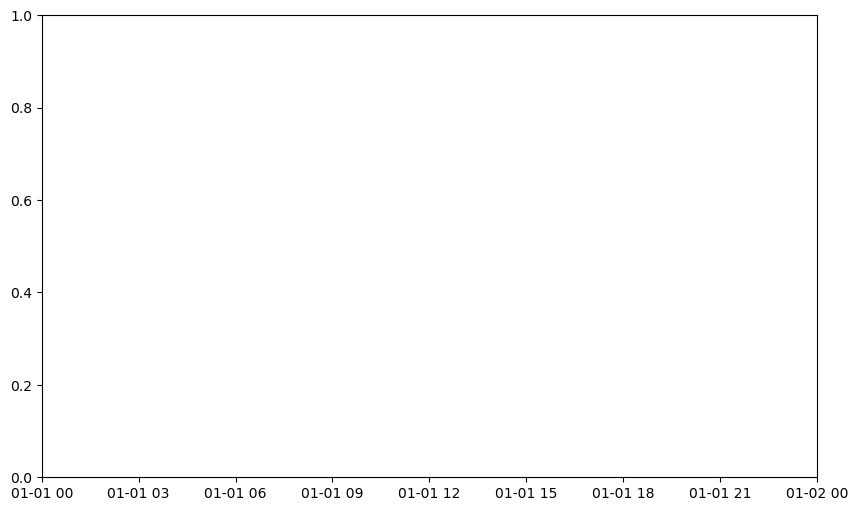

In [16]:
BMO = tickers[0]
RBC = tickers[2]
gross_returns = np.array([])
net_returns = np.array([])
t_s = np.array([])
# trading rule executes when 2 standard deviations away from the mean
t_threshold = -1.8
# Liquidity risk based on the typical spread of a stock - large cap: 0.01%-0.10% mid cap: 0.05%-0.20% small cap: 0.20%-1.00%
# Can add a trading fee as a percentage of the price to the spread
spread = 0.0005  # large to mid cap
window = 252

for t in range(window, len(data)):
    # stock[1]= a + b * stock[0]
    def unit_root(b):
        a = np.average(data[RBC][t-window:t] - b*data[BMO][t-window:t])
        fair_value = a + b*data[BMO][t-window:t]
        diff = np.array(fair_value - data[RBC][t-window:t])
        diff_diff = diff[1:] - diff[:-1]
        reg = sm.OLS(diff_diff, diff[:-1])
        res = reg.fit()
        return res.params[0]/res.bse[0]
    
    res1 = spop.minimize(unit_root, data[RBC][t]/data[BMO][t], method='Nelder-Mead')
    t_opt = res1.fun
    b_opt = float(res1.x)
    a_opt = np.average(data[RBC][t-window:t] - b_opt*data[BMO][t-window:t])
    fair_value = a_opt + b_opt*data[BMO][t]
    # optimizing cointegration equation parameters
    if t == window:
        old_signal = 0
    if t_opt > t_threshold:
        signal = 0
        gross_return = 0
    else:
        signal = np.sign(fair_value - data[RBC][t])
        gross_return = signal*returns[RBC][t] - signal*returns[BMO][t]
    fees = spread*abs(signal - old_signal)
    net_return = gross_return - fees
    gross_returns = np.append(gross_returns, gross_return)
    net_returns = np.append(net_returns, net_return)
    t_s = np.append(t_s, t_opt)
    # simulate trading
    print('day' + str(data.index[t]))
    print('')
    if signal == 0:
        print('no trading')
    elif signal == 1:
        print('long position on ' + RBC + ' and short position on ' + BMO)
    else:
        print('long position on ' + BMO + ' and short position on ' + RBC)
    print('gross daily return: ' + str(round(gross_return*100, 2)) + '%')
    print('net daily return: ' + str(round(net_return*100, 2)) + '%')
    print('cumulative net returns: ' + str(round(np.prod(1+net_returns)*100-100, 2)) + '%')
    print('')
    old_signal = signal

# plotting daily positions and realized returns
dates = data.index[window:]
plt.figure(figsize=(10, 6))
plt.plot(dates, np.append(1, np.cumprod(1+gross_returns)), label='Gross Returns')
plt.plot(dates, np.append(1, np.cumprod(1+net_returns)), label='Net Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Daily Positions and Realized Returns')
plt.legend()
plt.show()

## KPSS Strategy

In [ ]:
#specifying rolling window length
window = 21
#specifying maximum KPSS statistic (95% critical value)
KPSS_max = 0.463
#specifying the KPSS test (one-parameter unbiased or two-parameter)
unbiased = 1
#specifying whether to perform beta-loading or not
beta_loading = 0
#strategy parameters - trading fee, optimal entry (divergence), and stop-loss
fee = 0.0001
entry = 0.02
stop_loss = -0.05
#initially start in cash
signal = 0
current_return = 0
position0 = 0
position1 = 0
#specifying the sample
start = '2019-09-28'
end = '2021-09-28'
#specifying the pair
tickers = ['RY', 'CM']
#specifying the market index
market = 'TXBA.TS'
#initialising arrays
gross_returns = np.array([])
net_returns = np.array([])
market_returns = np.array([])
signals = np.array([])
KPSS_stats = np.array([])
raw_data = pd.DataFrame()
#downloading price data for stocks and the market index
for ticker in tickers:
    raw_data[ticker] = yf.download(ticker, start, end)['Close']
raw_data['market'] = yf.download(market, start, end)['Close']
#moving in a loop through the sample
for t in range(window, len(raw_data)-1):
    old_signal = signal
    old_position0 = position0
    old_position1 = position1
    #specifying the subsample
    data = raw_data[t-window:t]
    #stock 2 = a + b*stock 1
    #OLS parameters as starting values
    reg = sm.OLS(np.array(data[tickers[1]]), sm.add_constant(np.array(data[tickers[0]])))
    res = reg.fit()
    a0 = res.params[0]
    b0 = res.params[1]
    if unbiased == 1:
        #defining the KPSS function (unbiased one-parameter forecast)
        def KPSS(b):
            a = np.average(data[tickers[1]] - b*data[tickers[0]])
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS, b0, method='Nelder-Mead')
        KPSS_opt = res.fun
        #retrieving optimal parameters
        b_opt = float(res.x)
        a_opt = np.average(data[tickers[1]] - b_opt*data[tickers[0]]) 
    else:
        #defining the KPSS function (two-parameter)
        def KPSS2(kpss_params):
            a = kpss_params[0]
            b = kpss_params[1]
            resid = np.array(data[tickers[1]] - (a + b*data[tickers[0]]))
            cum_resid = np.cumsum(resid)
            st_error = (np.sum(resid**2)/(len(resid)-2))**(1/2)
            KPSS = np.sum(cum_resid**2)/(len(resid)**2*st_error**2)
            return KPSS
        #minimising the KPSS function (maximising the stationarity)
        res = spop.minimize(KPSS2, [a0, b0], method='Nelder-Mead')
        #retrieving optimal parameters
        KPSS_opt = res.fun
        a_opt = res.x[0]
        b_opt = res.x[1]
    #simulate trading
    #first check whether stop-loss is violated
    if current_return < stop_loss:
        signal = 0
        print('stop-loss triggered')
    #if we are already in position, check whether the equilibrium is restored, continue in position if not
    elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
        singal = old_signal
    else:
        #only trade if the pair is cointegrated
        if KPSS_opt > KPSS_max:
            signal = 0
        #only trade if there are large enough profit opportunities (optimal entry)
        elif abs(raw_data[tickers[1]][t]/(a_opt + b_opt*raw_data[tickers[0]][t])-1) < entry:
            signal = 0
        else:
            signal = np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t]))
    #calculate strategy returns with beta loading
    if beta_loading == 1:
        rets0 = np.array(raw_data[tickers[0]][t-window:t-1])/np.array(raw_data[tickers[0]][t-window+1:t]) - 1
        rets1 = np.array(raw_data[tickers[1]][t-window:t-1])/np.array(raw_data[tickers[1]][t-window+1:t]) - 1
        rets_mkt = np.array(raw_data['market'][t-window:t-1])/np.array(raw_data['market'][t-window+1:t]) - 1
        reg = sm.OLS(rets0, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta0 = res.params[1]
        reg = sm.OLS(rets1, sm.add_constant(rets_mkt))
        res = reg.fit()
        beta1 = res.params[1]
        position0 = beta1*signal
        position1 = -beta0*signal
    #calculate strategy returns without beta loading
    else:
        position0 = signal
        position1 = -signal
    #calculating returns
    gross = position0*(raw_data[tickers[0]][t+1]/raw_data[tickers[0]][t] - 1) + position1*(raw_data[tickers[1]][t+1]/raw_data[tickers[1]][t] - 1)
    net = gross - fee*(abs(position0 - old_position0) + abs(position1 - old_position1))
    market = raw_data['market'][t+1]/raw_data['market'][t] - 1
    if signal == old_signal:
        current_return = (1+current_return)*(1+gross)-1
    else:
        current_return = gross
    #populating arrays
    KPSS_stats = np.append(KPSS_stats, KPSS_opt)
    signals = np.append(signals, signal)
    gross_returns = np.append(gross_returns, gross)
    net_returns = np.append(net_returns, net)
    market_returns = np.append(market_returns, market)
#building the output dataframe
output = pd.DataFrame()
output['KPSS'] = KPSS_stats
output['signal'] = signals
output['gross'] = gross_returns
output['net'] = net_returns
output['market'] = market_returns
#visualising the results
plt.plot(np.append(1,np.cumprod(1+gross_returns)))
plt.plot(np.append(1,np.cumprod(1+net_returns)))
plt.plot(np.append(1,np.cumprod(1+market_returns)));